In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Data Generation

# Experiment Parameter
exp1_communication_round = 10

delta = 1e6
# Data Generation Parameter
exp1_dim = 1
exp1_no_clients = 2
exp1_sync_gap = int(exp1_communication_round/ exp1_no_clients)

exp1_m = [1] * exp1_no_clients 

exp1_mu = 1

exp1_M_client = [np.eye(2*exp1_dim)]*2
exp1_z_client = [np.array((-delta, 0)), np.array((0, -delta))]

exp1_M_mean = np.mean(exp1_M_client, axis = 0)
exp1_z_mean = np.mean(exp1_z_client, axis = 0)

# Note that cocoercivity parameter is computed specific to this problem
exp1_l_cocoercive = 2 * delta

exp1_lipschitz_client = [np.sqrt(max(np.linalg.eig(exp1_M_client[0].T @ exp1_M_client[0])[0])), np.sqrt(max(np.linalg.eig(exp1_M_client[1].T @ exp1_M_client[1])[0]))]
exp1_lipschitz = np.sqrt(max(np.linalg.eig(exp1_M_mean.T @ exp1_M_mean)[0]))
exp1_x_optimal = -np.linalg.inv(exp1_M_mean) @ exp1_z_mean


def exp1_operator(x, client_idx = None, m_idx = None):
    if client_idx == None and m_idx == None:
        return exp1_M_mean @ x + exp1_z_mean
    elif m_idx == None:
        return exp1_M_client[client_idx] @ x + exp1_z_client[client_idx]
    else:
        return exp1_M[client_idx][m_idx] @ x + exp1_z[client_idx][m_idx]

In [3]:
def ProxSkip_VIP_FL(x_initial, x_optimal, no_client, m, gamma, prob, operator, communication_round = 1000, deterministic = True):
    x = x_initial
    dim = len(x_initial)
    initial_error = np.sum((x - x_optimal)**2)
    error = [1]
    
    control_variate_client = np.zeros((no_client, dim))
    x_client = np.ones((no_client, 1)) * x
    x_hat_client = np.zeros((no_client, dim))
    x_dash_client = np.zeros((no_client, dim))
    
    rounds = 0
    while rounds < (communication_round - 1):
        theta = np.random.binomial(1, p = prob)
        
        if theta == 1:
            rounds += 1
            for client_idx in range(no_client):
                if deterministic == True:
                    g_client = operator(x_client[client_idx], client_idx)/ no_client
                else:
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = operator(x_client[client_idx], client_idx, m_idx)/ no_client
                x_hat_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx]) 
                x_dash_client[client_idx] = x_hat_client[client_idx] - (gamma/ prob) * control_variate_client[client_idx]
            
            x = np.mean(x_dash_client, axis= 0)
            x_client = np.ones((no_client, 1)) * x
            error.append(np.sum((x - x_optimal)**2)/ initial_error)
    
            for client_idx in range(no_client):
                control_variate_client[client_idx] = control_variate_client[client_idx] + (prob/ gamma) * (x_client[client_idx] - x_hat_client[client_idx])
        else:
            for client_idx in range(no_client):
                if deterministic == True:
                    g_client = operator(x_client[client_idx], client_idx)/ no_client
                else:
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = operator(x_client[client_idx], client_idx, m_idx)/ no_client
                x_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx])
        
    return error
    
def local_SGDA(x_initial, x_optimal, no_client, m, L, mu, operator, sync_gap, communication_round = 1000, deterministic = True):
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    kappa = L/mu
    a = 2048*sync_gap*(kappa**2)
    
    x_client = np.ones((no_client, 1)) * x
    
    total_iteration = 0
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        
        for client_idx in range(no_client):
            x_client[client_idx] = x
            
            for iteration in range(sync_gap):
                if deterministic == True:
                    total_iteration += 1
                    gamma = 8/(mu * (total_iteration + a))
                    x_client[client_idx] = x_client[client_idx] - gamma * operator(x_client[client_idx], client_idx)
                else:
                    total_iteration += 1
                    gamma = 8/(mu * (total_iteration + a))
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    x_client[client_idx] = x_client[client_idx] - gamma * operator(x_client[client_idx], client_idx, m_idx)
    return error

def local_SEG(x_initial, x_optimal, no_client, m, gamma1, gamma2, operator, sync_gap, communication_round = 1000, deterministic = True):
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    
    x_client = np.ones((no_client, 1)) * x
    
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        
        for client_idx in range(no_client):
            x_client[client_idx] = x
            
            for iteration in range(sync_gap):
                if deterministic == True:
                    x_client_mid = x_client[client_idx] - gamma1 * operator(x_client[client_idx], client_idx)
                    x_client[client_idx] = x_client[client_idx] - gamma2 * operator(x_client_mid, client_idx)
                else:
                    m1_idx, m2_idx = np.random.choice(m[client_idx], 2)
                    x_client_mid = x_client[client_idx] - gamma1 * operator(x_client[client_idx], client_idx, m1_idx)
                    x_client[client_idx] = x_client[client_idx] - gamma2 * operator(x_client_mid, client_idx, m2_idx)
    return error


In [4]:
ProxSkip_error = ProxSkip_VIP_FL(np.ones(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(2 * exp1_lipschitz), 1/exp1_sync_gap, exp1_operator, communication_round= exp1_communication_round)
local_GDA_error = local_SGDA(np.ones(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, exp1_lipschitz, exp1_mu, exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)
local_EG_error = local_SEG(np.ones(2 * exp1_dim), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)

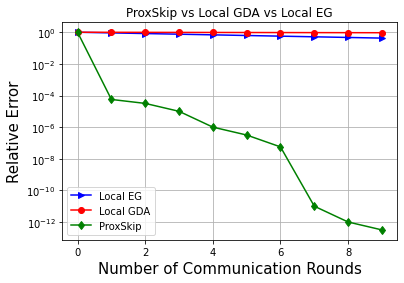

In [5]:
fig = plt.figure()
markers_on = np.arange(0, exp1_communication_round, exp1_communication_round/10).astype(int).tolist()

plt.plot(np.arange(exp1_communication_round), local_EG_error,'-b>', markevery = markers_on, label = 'Local EG')
plt.plot(np.arange(exp1_communication_round), local_GDA_error,'-ro', markevery = markers_on, label = 'Local GDA')
plt.plot(np.arange(exp1_communication_round), ProxSkip_error, '-gd', markevery = markers_on, label = 'ProxSkip')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Communication Rounds", fontsize = 15)
plt.legend(fontsize = 10)
plt.title("ProxSkip vs Local GDA vs Local EG")
plt.savefig(f"Plots/ProxSkip vs Local GDA vs Local_EG with Theoretical stepsize on Hetergeneous Data with delta = {delta}.pdf", bbox_inches='tight')